In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics as sk_metrics

import data
import uncertainty_estimation as ue
from main_bayesian import getModel
import config_bayesian as cfg
import utils
import torch
import metrics
from torch.nn import functional as F
import config_bayesian as cfg




/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)

True
cuda:0


In [3]:
print(torch.cuda.device_count())
print(torch.version.cuda) 

1
11.0


### Calculate uncertainties
Load the model from checkpoint and test on testset

In [4]:
source = 0 # 0: work computer, 1: laptop. NOTE: also change in data.py

In [5]:
# Load data
trainset, testset, inputs, num_classes = data.getDataset('POCUS')
train_loader, valid_loader, test_loader = data.getDataloader(trainset, testset, cfg.valid_size, batch_size=1, num_workers=cfg.num_workers)

ckpt_name = 'model_alexnet_lrt_relu_2023-10-04'

loc_pc = '/home/marisa/Documents'
loc_lap = 'C:/Users/maris/Documents/Thesis'
locs = [loc_pc, loc_lap]
loc = locs[source]

# Load model
ckpt = f'{loc}/PyTorch-BayesianCNN/checkpoints/POCUS/bayesian/{ckpt_name}.pt'
layer_type = cfg.layer_type
activation_type = cfg.activation_type

net = getModel('alexnet', inputs, num_classes, priors=None, layer_type=layer_type, activation_type=activation_type)
net = net.to(device)
net.load_state_dict(torch.load(ckpt, map_location=device)["model_state_dict"])
net.train() # should this be train or eval?


found data in  /home/marisa/Documents/Thesis/Data/POCUS_and_US/Train/  :  1236
found data in  /home/marisa/Documents/Thesis/Data/POCUS_and_US/Test/  :  531


BBBAlexNet(
  (conv1): BBBConv2d()
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): BBBConv2d()
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): BBBConv2d()
  (act3): ReLU()
  (conv4): BBBConv2d()
  (act4): ReLU()
  (conv5): BBBConv2d()
  (act5): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): FlattenLayer()
  (classifier): BBBLinear()
)

In [22]:
def evaluate_uncertainties(model):

    n_samples = len(testset)
    
    uncertainties = []

    for idx in range(n_samples):
        sample, truth = testset[idx]
        sample = sample.to(device)

        pred, epi_norm, ale_norm = ue.get_uncertainty_per_image(net, sample, T=25, normalized=True)
        pred, epi_soft, ale_soft = ue.get_uncertainty_per_image(net, sample, T=25, normalized=False)

        pred = int(np.argmax(pred))
        uncertainties.append([epi_norm[pred], ale_norm[pred], epi_soft[pred], ale_soft[pred], truth==pred, truth, pred])


    return uncertainties


In [7]:
uncertainties = evaluate_uncertainties(net)

### Uncertainties and Accuracies together

In [31]:
# do a combined function that calculates uncertainties and accuracies at once and store it all together in a dataframe

def uq_acc(net, criterion, testset, beta_type=0.1, epoch=None, num_epochs=None, T=30):
    
    net.eval()
    print('number of images: ', len(testset))

    df = [] # store per image: prediction, true label, loss, accuracy, epistemic uncertainty, aleatoric uncertainty

    for i in range(len(testset)):
        input_image, label = testset[i]
        input_image = input_image.unsqueeze(0).to(device)
        label = torch.tensor([label]).to(device)
   
        kl = 0.0
        outputs = torch.zeros(1, net.num_classes, T).to(device)
        for j in range(T):
            net_out, _kl = net(input_image)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

        kl = kl / T
        pred = torch.mean(outputs, dim=2)
        log_outputs = utils.logmeanexp(outputs, dim=2)
        outputs = outputs.squeeze(0)

        # calculate loss and accuarcy
        beta = metrics.get_beta(i-1, len(testset), beta_type, epoch, num_epochs)
        loss = criterion(log_outputs, label, kl, beta).item()
        acc = metrics.acc(log_outputs, label)


        # normalized uncertainties
        prediction = F.softplus(outputs)
        p_hat_n = prediction / torch.sum(prediction, dim=1).unsqueeze(1)

        p_hat_n = p_hat_n.detach().cpu().numpy()
        p_bar_n = np.mean(p_hat_n, axis=0)

        temp_n = p_hat_n - np.expand_dims(p_bar_n, 0)
        epistemic_n = np.dot(temp_n.T, temp_n) / T
        epistemic_n = np.diag(epistemic_n)

        aleatoric_n = np.diag(p_bar_n) - (np.dot(p_hat_n.T, p_hat_n) / T)
        aleatoric_n = np.diag(aleatoric_n)

        # softmax uncertainties
        p_hat_s = F.softmax(outputs)
        
        p_hat_s = p_hat_s.detach().cpu().numpy()
        p_bar_s = np.mean(p_hat_s, axis=0)

        temp_s = p_hat_s - np.expand_dims(p_bar_s, 0)
        epistemic_s = np.dot(temp_s.T, temp_s) / T
        epistemic_s = np.diag(epistemic_s)

        aleatoric_s = np.diag(p_bar_s) - (np.dot(p_hat_s.T, p_hat_s) / T)
        aleatoric_s = np.diag(aleatoric_s)

        pred = pred.detach().cpu().numpy()
        pred = int(np.argmax(pred))
        label = int(label.detach().cpu().numpy())

        # save to dataframe
        df.append([pred, label, loss, acc, epistemic_n[pred], aleatoric_n[pred], epistemic_s[pred], aleatoric_s[pred]])

    return df

In [32]:
criterion = metrics.ELBO(len(testset)).to(device)
df = uq_acc(net, criterion, testset, beta_type=0.1, epoch=None, num_epochs=None, T=30)

number of images:  531


/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [33]:
# make dataframe into pandas dataframe and display
import pandas as pd
df = pd.DataFrame(df, columns=['pred', 'label', 'loss', 'acc', 'epi_n', 'ale_n', 'epi_s', 'ale_s'])
print(df)

     pred  label        loss  acc     epi_n     ale_n     epi_s     ale_s
0       1      1  17824822.0  1.0  0.000003  0.027933  0.000004  0.027538
1       1      1  17825052.0  1.0  0.000007  0.031119  0.000009  0.030869
2       0      1  17825178.0  0.0  0.000024  0.030984  0.000030  0.031486
3       1      1  17825034.0  1.0  0.000013  0.028023  0.000014  0.027736
4       1      1  17824832.0  1.0  0.000009  0.024442  0.000011  0.024185
..    ...    ...         ...  ...       ...       ...       ...       ...
526     0      2  17825872.0  0.0  0.000005  0.037300  0.000006  0.036827
527     0      2  17826146.0  0.0  0.000001  0.030855  0.000002  0.030405
528     1      2  17825126.0  0.0  0.000004  0.030532  0.000004  0.030152
529     1      2  17825376.0  0.0  0.000015  0.033856  0.000019  0.033960
530     2      2  17825042.0  1.0  0.000022  0.034959  0.000029  0.035388

[531 rows x 8 columns]


In [34]:
# DATA FRAME INSPECTION
# look at min and max values for each column
print(df.describe())


             pred       label          loss         acc         epi_n  \
count  531.000000  531.000000  5.310000e+02  531.000000  5.310000e+02   
mean     0.404896    0.681733  1.782515e+07    0.598870  2.341489e-05   
std      0.556178    0.809394  3.504059e+02    0.490589  4.882316e-05   
min      0.000000    0.000000  1.782470e+07    0.000000  5.535055e-08   
25%      0.000000    0.000000  1.782490e+07    0.000000  6.399411e-06   
50%      0.000000    0.000000  1.782505e+07    1.000000  1.299829e-05   
75%      1.000000    1.000000  1.782529e+07    1.000000  2.266240e-05   
max      2.000000    2.000000  1.782688e+07    1.000000  6.683638e-04   

            ale_n         epi_s       ale_s  
count  531.000000  5.310000e+02  531.000000  
mean     0.033206  2.889865e-05    0.033206  
std      0.007883  6.285527e-05    0.008216  
min      0.016277  8.066137e-08    0.016274  
25%      0.028527  7.661596e-06    0.028347  
50%      0.032096  1.514796e-05    0.031836  
75%      0.036279  2

In [35]:
def auc(predicted_labels, test_labels):

    result_binarize= [1 if x==2 else 0 for x in predicted_labels] #Malignant vs Benign and Normal
    labels_binarize = [1 if x==2 else 0 for x in test_labels]

    auc = sk_metrics.roc_auc_score(labels_binarize, result_binarize)

    return auc

### Data inspection 
Look at the data with PCA and t-SNE

In [36]:
test_data = [elem[0].numpy().reshape(-1, 180*180).reshape(-1) for elem in testset]
test_labels = [elem[1] for elem in testset]

In [37]:
print('shape of test data: ', np.shape(test_data))

shape of test data:  (531, 32400)


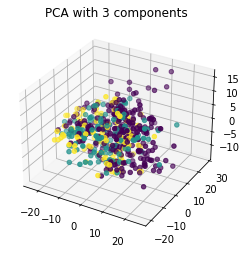

In [48]:
# PCA with 3 components
pca = PCA(n_components=3)

# fit the data (images) that is in the testset
pca_result = pca.fit_transform(test_data)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(xs=[i[0] for i in pca_result], ys=[i[1] for i in pca_result], zs=[i[2] for i in pca_result], c=[i[5] for i in uncertainties])
ax.scatter(xs=[i[0] for i in pca_result], ys=[i[1] for i in pca_result], zs=[i[2] for i in pca_result], c=[df['label']])
plt.title('PCA with 3 components')
plt.show()


/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


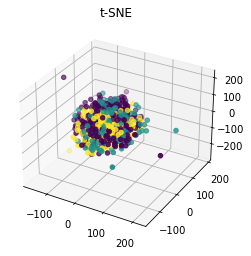

In [49]:
# t-SNE with 3 components (use PCA to reduce the dimensionality of the data first), color by label
pca = PCA(n_components=30)
pca_result = pca.fit_transform(test_data)
tsne = TSNE(n_components=3)
tsne_result = tsne.fit_transform(pca_result)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=[i[0] for i in tsne_result], ys=[i[1] for i in tsne_result], zs=[i[2] for i in tsne_result], c=[df['label']])
plt.title('t-SNE')
plt.show()


Check how many correct and wrong prediction there were

In [51]:
"""
class_map = {"Normal" : 0, "Benign": 1, "Malignant": 2}
class_names = ["Normal", "Benign", "Malignant"]

# count how many right and worng predictions there are for each class
right = [0 for i in range(num_classes)]
wrong = [0 for i in range(num_classes)]
for i in uncertainties:
    if i[4]:
        right[int(i[5])] += 1
    else:
        wrong[int(i[5])] += 1

for i in range(num_classes):
    print('Class', i, ' - ', class_names[i] , ' - ', 'Right:', right[i], ' , ', 'Wrong:', wrong[i])


# check how often which label was predicted and how often it was correct
pred = [0 for i in range(num_classes)]
correct = [0 for i in range(num_classes)]
for i in uncertainties:
    pred[int(i[6])] += 1
    if i[4]:
        correct[int(i[6])] += 1

for i in range(num_classes):
    print('Class', i, ' - Prediction ', class_names[i] , ' - ', 'Predicted:', pred[i], ' , ', 'of which were correct:', correct[i])
"""


'\nclass_map = {"Normal" : 0, "Benign": 1, "Malignant": 2}\nclass_names = ["Normal", "Benign", "Malignant"]\n\n# count how many right and worng predictions there are for each class\nright = [0 for i in range(num_classes)]\nwrong = [0 for i in range(num_classes)]\nfor i in uncertainties:\n    if i[4]:\n        right[int(i[5])] += 1\n    else:\n        wrong[int(i[5])] += 1\n\nfor i in range(num_classes):\n    print(\'Class\', i, \' - \', class_names[i] , \' - \', \'Right:\', right[i], \' , \', \'Wrong:\', wrong[i])\n'

In [52]:
class_map = {"Normal" : 0, "Benign": 1, "Malignant": 2}
class_names = ["Normal", "Benign", "Malignant"]

# count how many right and wrong predictions there are for each class in the dataframe
right = [0 for i in range(num_classes)]
wrong = [0 for i in range(num_classes)]
for i in range(len(df)):
    if df['pred'][i] == df['label'][i]:
        right[int(df['label'][i])] += 1
    else:
        wrong[int(df['label'][i])] += 1

for i in range(num_classes):
    print('Class', i, ' - ', class_names[i] , ' - ', 'Right:', right[i], ' , ', 'Wrong:', wrong[i])


Class 0  -  Normal  -  Right: 234  ,  Wrong: 51
Class 1  -  Benign  -  Right: 72  ,  Wrong: 58
Class 2  -  Malignant  -  Right: 14  ,  Wrong: 102


In [53]:
# check how often which label was predicted and how often it was correct

pred = [0 for i in range(num_classes)]
correct = [0 for i in range(num_classes)]
for i in range(len(df)):
    pred[int(df['pred'][i])] += 1
    if df['pred'][i] == df['label'][i]:
        correct[int(df['pred'][i])] += 1

for i in range(num_classes):
    print('Class', i, ' - Prediction ', class_names[i] , ' - ', 'Predicted:', pred[i], ' , ', 'of which were correct:', correct[i])


Class 0  - Prediction  Normal  -  Predicted: 334  ,  of which were correct: 234
Class 1  - Prediction  Benign  -  Predicted: 179  ,  of which were correct: 72
Class 2  - Prediction  Malignant  -  Predicted: 18  ,  of which were correct: 14


### Uncertainty visualization

Normalized epistemic uncertainty

In [68]:
def sort_uncertainties(u_type, normalized, uncertainties, as_tensor=False):
    
    # get the correct index at which the uncertainty is stored
    if u_type == 'epistemic':
        if normalized:
            u = 0
        else:
            u = 2
    elif u_type == 'aleatoric':
        if normalized:
            u = 1
        else:
            u = 3
    
    # split the testset into 5 groups based on epistemic uncertainty (normalized)
    testset0, testset1, testset2, testset3, testset4 = [], [], [], [], []
    labels0, labels1, labels2, labels3, labels4 = [], [], [], [], []

    # create thresholds 
    t0 = min([i[u] for i in uncertainties])
    t5 = max([i[u] for i in uncertainties])
    steps = (t5-t0) / 5

    t1 = t0 + steps
    t2 = t1 + steps
    t3 = t2 + steps
    t4 = t3 + steps

    for i, elem in enumerate(uncertainties):
        if elem[u] < t1:
            if as_tensor:
                testset0.append(testset[i][0])
                labels0.append([elem[5]])
            else:
                testset0.append(testset[i][0].numpy().reshape(-1, 180*180).reshape(-1))
                labels0.append(elem[5])
        elif elem[u] < t2:
            if as_tensor:
                testset1.append(testset[i][0])
                labels1.append([elem[5]])
            else:
                testset1.append(testset[i][0].numpy().reshape(-1, 180*180).reshape(-1))
                labels1.append(elem[5])
        elif elem[u] < t3:
            if as_tensor:
                testset2.append(testset[i][0])
                labels2.append([elem[5]])
            else:
                testset2.append(testset[i][0].numpy().reshape(-1, 180*180).reshape(-1))
                labels2.append(elem[5])
        elif elem[u] < t4:
            if as_tensor:
                testset3.append(testset[i][0])
                labels3.append([elem[5]])
            else:
                testset3.append(testset[i][0].numpy().reshape(-1, 180*180).reshape(-1))
                labels3.append(elem[5])
        else:
            if as_tensor:
                testset4.append(testset[i][0])
                labels4.append([elem[5]])
            else:
                testset4.append(testset[i][0].numpy().reshape(-1, 180*180).reshape(-1))
                labels4.append(elem[5])

    testsets = [testset0, testset1, testset2, testset3, testset4]
    thresholds = [t0, t1, t2, t3, t4, t5]
    labelssets = [labels0, labels1, labels2, labels3, labels4]
    vals = ["small", "small-medium", "medium", "medium-large", "large"]

    return testsets, thresholds, labelssets, vals


In [16]:
# t-SNE with 3 components (use PCA to reduce the dimensionality of the data first), color by label
def plot_tsne(uncertainties, u_type='epistemic', normalized=True):

    testsets, thresholds, labelssets, vals = sort_uncertainties(u_type, normalized, uncertainties)

    for i in range(len(testsets)):

        set_i = testsets[i]
        labels_i = labelssets[i]
        if len(set_i) > 2:
            if len(labels_i) < 30:
                n_components = len(labels_i)
            else:
                n_components = 30
            pca = PCA(n_components=n_components)
            pca_result = pca.fit_transform(set_i)
            tsne = TSNE(n_components=3)
            tsne_result = tsne.fit_transform(pca_result)
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(xs=[i[0] for i in tsne_result], ys=[i[1] for i in tsne_result], zs=[i[2] for i in tsne_result], c=labels_i)
            plt.title('t-SNE for ' + vals[i] + ' epistemic uncertainty (normalized) (between ' + str(thresholds[i]) + ' and ' + str(thresholds[i+1]) + ')')
            plt.show()
        else:
            print('too little data in this group to plot t-SNE')

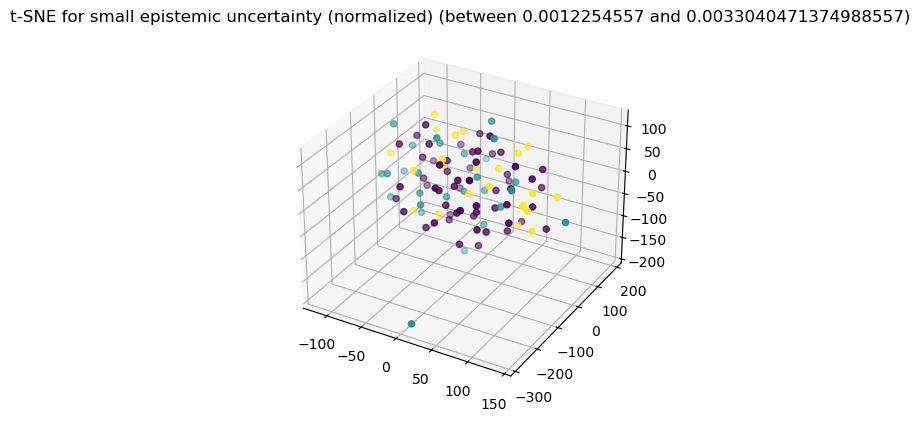

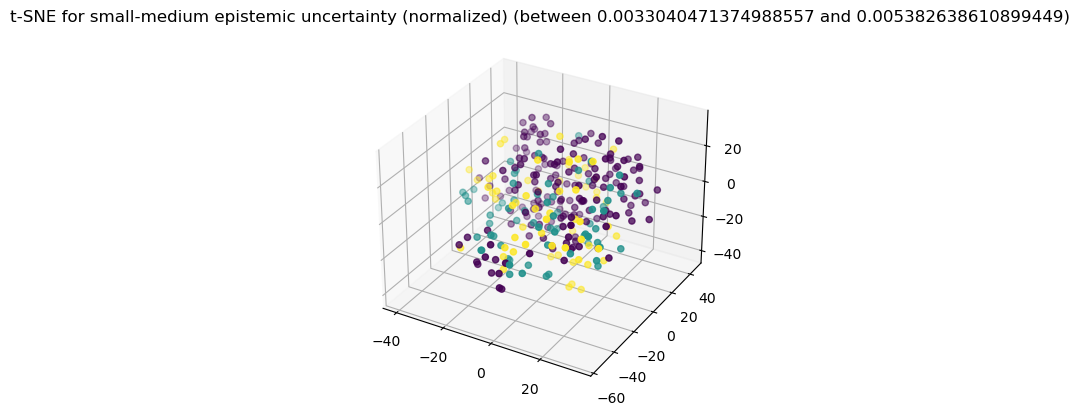

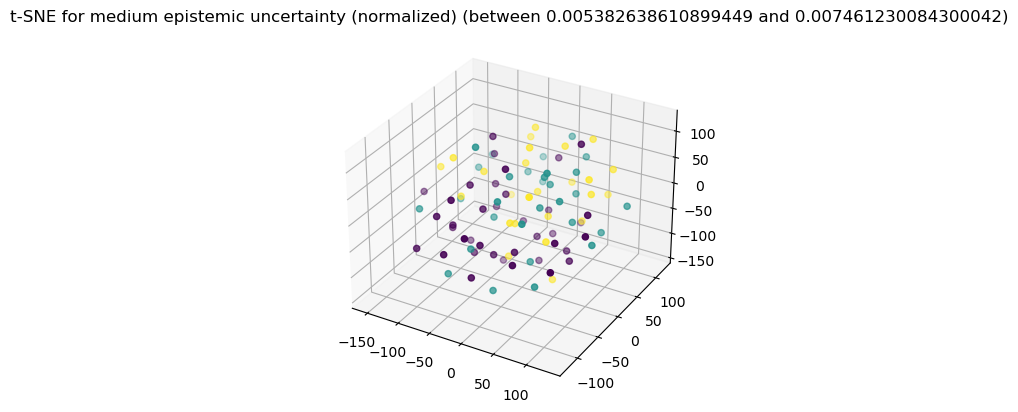

ValueError: perplexity must be less than n_samples

In [17]:
plot_tsne(uncertainties, u_type='epistemic', normalized=True)

In [18]:
plot_tsne(uncertainties, u_type='epistemic', normalized=False)

too little data in this group to plot t-SNE
too little data in this group to plot t-SNE
too little data in this group to plot t-SNE


ValueError: perplexity must be less than n_samples

too little data in this group to plot t-SNE
too little data in this group to plot t-SNE
too little data in this group to plot t-SNE
too little data in this group to plot t-SNE


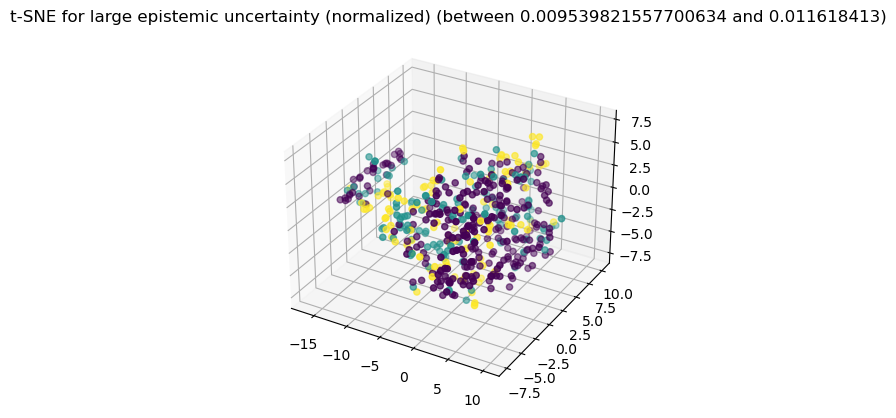

In [19]:
plot_tsne(uncertainties, u_type='aleatoric', normalized=True)

too little data in this group to plot t-SNE
too little data in this group to plot t-SNE
too little data in this group to plot t-SNE
too little data in this group to plot t-SNE


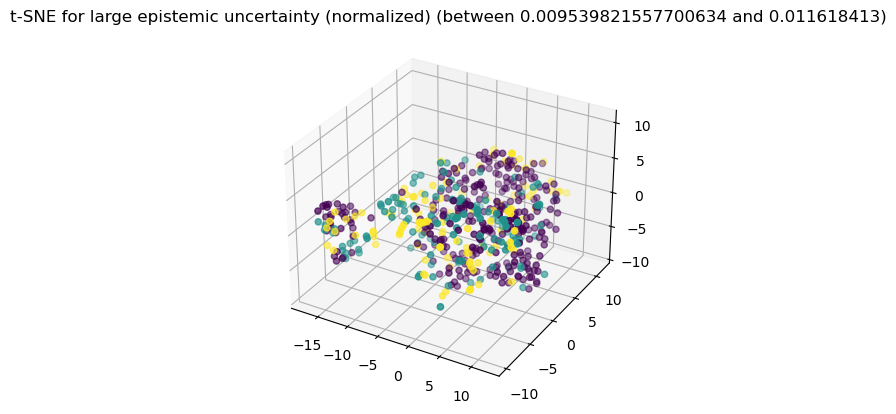

In [20]:
plot_tsne(uncertainties, u_type='aleatoric', normalized=False)

Calculate the accuracy for the different subsets

In [69]:
def validate_model(net, criterion, testset, labelsset, num_ens=30, beta_type=0.1, epoch=None, num_epochs=None):
    """Calculate accuracy and NLL Loss"""
    net.eval()
    valid_loss = 0.0
    accs = []
    print('number of images: ', len(testset))

    for i in range(len(testset)):
        inputs, labels = testset[i], labelsset[i]
        inputs, labels = inputs.to(device), labels.to(device)

        # add one dimension to the inputs
        inputs = inputs.unsqueeze(0)

        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)
        kl = 0.0
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

        log_outputs = utils.logmeanexp(outputs, dim=2)
        beta = metrics.get_beta(i-1, len(testset), beta_type, epoch, num_epochs)
        valid_loss += criterion(log_outputs, labels, kl, beta).item()
        accs.append(metrics.acc(log_outputs, labels))

    return valid_loss/len(testset), np.mean(accs)

In [70]:
def acc_by_uncertainty(u_type, normalized, uncertainties):

    vals = ["small", "small-medium", "medium", "medium-large", "large"]

    testsets, thresholds, labelssets, vals = sort_uncertainties(u_type=u_type, normalized=normalized, uncertainties=uncertainties, as_tensor=True)
    

    for i in range(len(testsets)):

        print('Evaluating for ' + vals[i] + ' uncertainties')

        set_i = testsets[i]
        labels_i = labelssets[i]

        # transform the data into a tensor
        labels_i = torch.tensor(labels_i)
        set_i = torch.stack(set_i)
        #print('set shape: ', set_i.shape)

        criterion = metrics.ELBO(len(set_i)).to(device)
        valid_loss, valid_acc = validate_model(net, criterion, set_i, labels_i, num_ens=1, beta_type=0.1, epoch=None, num_epochs=None)

        print('Validation Loss: %.8f, Validation Accuracy: %.2f' % (valid_loss, valid_acc))



In [71]:
acc_by_uncertainty(u_type='epistemic', normalized=True, uncertainties=uncertainties)

Evaluating for small uncertainties
number of images:  109
Validation Loss: 17824767.39449541, Validation Accuracy: 0.57
Evaluating for small-medium uncertainties
number of images:  304
Validation Loss: 17824979.96710526, Validation Accuracy: 0.52
Evaluating for medium uncertainties
number of images:  93
Validation Loss: 17824763.20430107, Validation Accuracy: 0.56
Evaluating for medium-large uncertainties
number of images:  20
Validation Loss: 17824686.50000000, Validation Accuracy: 0.65
Evaluating for large uncertainties
number of images:  5
Validation Loss: 17824676.80000000, Validation Accuracy: 0.40


In [72]:
acc_by_uncertainty(u_type='epistemic', normalized=False, uncertainties=uncertainties)


Evaluating for small uncertainties
number of images:  49
Validation Loss: 17824704.57142857, Validation Accuracy: 0.65
Evaluating for small-medium uncertainties
number of images:  296
Validation Loss: 17824968.48648649, Validation Accuracy: 0.54
Evaluating for medium uncertainties
number of images:  158
Validation Loss: 17824822.36708861, Validation Accuracy: 0.56
Evaluating for medium-large uncertainties
number of images:  25
Validation Loss: 17824688.16000000, Validation Accuracy: 0.64
Evaluating for large uncertainties
number of images:  3
Validation Loss: 17824671.33333333, Validation Accuracy: 0.33


In [73]:
acc_by_uncertainty(u_type='aleatoric', normalized=True, uncertainties=uncertainties)


Evaluating for small uncertainties
number of images:  2
Validation Loss: 17824669.00000000, Validation Accuracy: 0.50
Evaluating for small-medium uncertainties
number of images:  7
Validation Loss: 17824675.14285714, Validation Accuracy: 0.43
Evaluating for medium uncertainties
number of images:  53
Validation Loss: 17824719.88679245, Validation Accuracy: 0.55
Evaluating for medium-large uncertainties
number of images:  141
Validation Loss: 17824838.66666667, Validation Accuracy: 0.46
Evaluating for large uncertainties
number of images:  328
Validation Loss: 17824964.63414634, Validation Accuracy: 0.60


In [74]:
acc_by_uncertainty(u_type='aleatoric', normalized=False, uncertainties=uncertainties)


Evaluating for small uncertainties
number of images:  2
Validation Loss: 17824668.00000000, Validation Accuracy: 1.00
Evaluating for small-medium uncertainties
number of images:  6
Validation Loss: 17824670.00000000, Validation Accuracy: 0.83
Evaluating for medium uncertainties
number of images:  22
Validation Loss: 17824680.90909091, Validation Accuracy: 0.82
Evaluating for medium-large uncertainties
number of images:  118
Validation Loss: 17824762.50847458, Validation Accuracy: 0.63
Evaluating for large uncertainties
number of images:  383
Validation Loss: 17825104.37075718, Validation Accuracy: 0.49


Plot PCA for different subsets

In [ ]:
# t-SNE with 3 components (use PCA to reduce the dimensionality of the data first), color by label
def plot_pca(uncertainties, u_type='epistemic', normalized=True):

    testsets, thresholds, labelssets, vals = sort_uncertainties(u_type, normalized, uncertainties)

    for i in range(len(testsets)):
        set_i = testsets[i]
        labels_i = labelssets[i]

        if len(set_i) > 2:
            
            # PCA with 3 components
            pca = PCA(n_components=3)

            # fit the data (images) that is in the testset
            pca_result = pca.fit_transform(set_i)
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(xs=[i[0] for i in pca_result], ys=[i[1] for i in pca_result], zs=[i[2] for i in pca_result], c=labels_i)
            plt.title('PCA for ' + vals[i] + ' epistemic uncertainty (normalized) (between ' + str(thresholds[i]) + ' and ' + str(thresholds[i+1]) + ')')
            plt.show()

        else:
            print("Not enough data points to plot PCA")

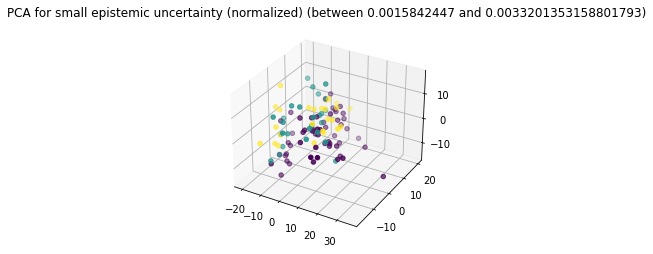

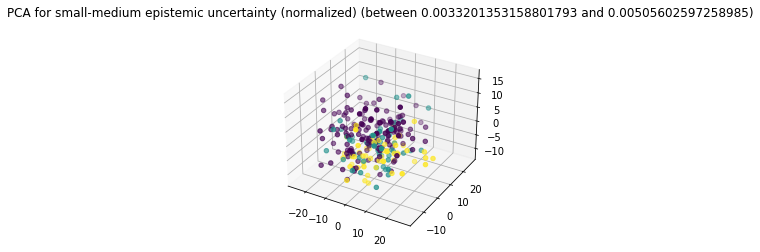

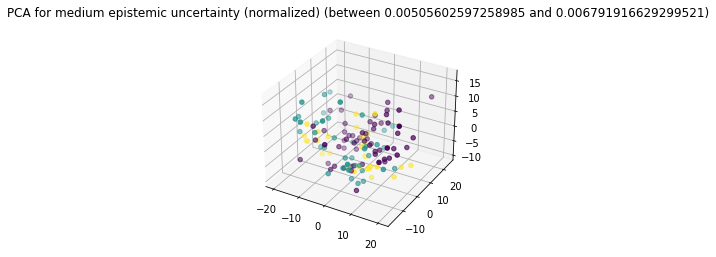

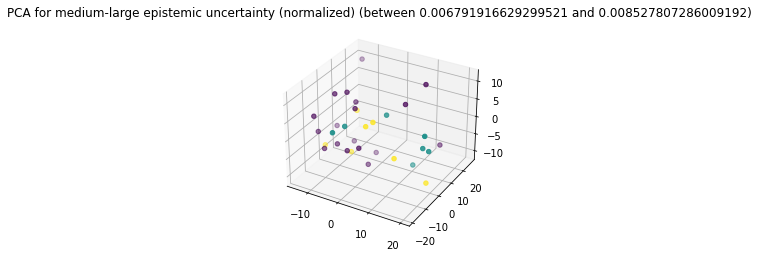

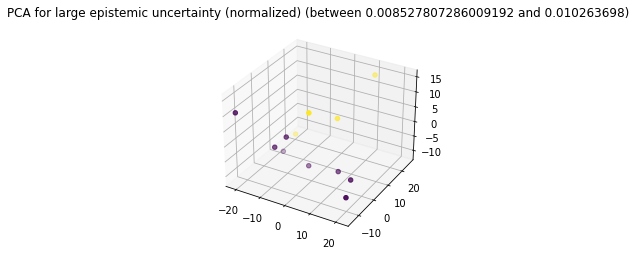

In [ ]:
plot_pca(uncertainties, u_type='epistemic', normalized=True)

# Inspect different subgroups in the data

### Subgroups based on uncertainty

### Subgroups based on class